In [1]:
from ray import tune
import ray
import copy
import yaml
import train_and_eval
import glob
import json

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
ray.init(log_to_driver=False)

/home/rah150030/.conda/envs/gpn2/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/rah150030/.conda/envs/gpn2/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
2022-10-31 23:56:31,825	INFO worker.py:1518 -- Started a local Ray instance.


RayContext(dashboard_url='', python_version='3.9.13', ray_version='2.0.0', ray_commit='cba26cc83f6b5b8a2ff166594a65cb74c0ec8740', address_info={'node_ip_address': '10.176.130.19', 'raylet_ip_address': '10.176.130.19', 'redis_address': None, 'object_store_address': '/tmp/ray/session_2022-10-31_23-56-29_916296_1671934/sockets/plasma_store', 'raylet_socket_name': '/tmp/ray/session_2022-10-31_23-56-29_916296_1671934/sockets/raylet', 'webui_url': '', 'session_dir': '/tmp/ray/session_2022-10-31_23-56-29_916296_1671934', 'metrics_export_port': 58831, 'gcs_address': '10.176.130.19:57774', 'address': '10.176.130.19:57774', 'dashboard_agent_listen_port': 52365, 'node_id': '099aa6fd56bce0dace17904fea4f36a0512ae524e83f5c95dd8134c5'})

In [2]:
def config_helper(config):
    return train_and_eval.run_experiment(**config)

with open('configs/gpn/ood_loc_gpn_16.yaml') as f:
    config = yaml.safe_load(f)

In [3]:
datasets = ['CoraML', 'CiteSeer', 'PubMed'] #, 'AmazonPhotos', 'AmazonComputers', 'CoauthorCS', 'CoauthorPhysics']

In [4]:
config['model']['orig_dist_reg'] = tune.grid_search([1.5 ** i for i in range(-80, -0)])
config['model']['dist_reg'] = tune.grid_search([0]) #[10 ** i for i in range(-6, -4)])
config['model']['KNN_K'] = tune.grid_search([1])
config['model']['normalize_dist_reg'] = tune.grid_search([False, ])
config['model']['dist_sigma'] = tune.grid_search([1])
config['model']['dist_embedding_beta'] = tune.grid_search([True, False])
config['data']['dataset'] = tune.grid_search(datasets)
results_orig = tune.run(
    config_helper,
    metric='test_ood_detection_epistemic_auroc',
    mode="max", 
    num_samples=1,
    max_concurrent_trials=16,
    resources_per_trial={"gpu": 0.5, 'cpu': 4},
    config=config,
    max_failures=10)

2022-10-31 23:56:33,156	WARNING function_trainable.py:619 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.


Result for config_helper_8e5fc_00004:
  date: 2022-10-31_23-57-10
  done: false
  experiment_id: 30746883868d4b0bafe225d7923ff8b4
  hostname: csr-93141
  iterations_since_restore: 1
  node_ip: 10.176.130.19
  pid: 1674019
  test_CE: 0.7930886745452881
  test_ECE: 0.0208867397159338
  test_accuracy: 0.7098121047019958
  test_average_entropy: 0.8114907145500183
  test_avg_prediction_confidence_aleatoric: 0.7044814229011536
  test_avg_prediction_confidence_epistemic: 2739.189208984375
  test_avg_sample_confidence_aleatoric: 0.7044814229011536
  test_avg_sample_confidence_epistemic: 3499.146240234375
  test_avg_sample_confidence_features: 3651.005859375
  test_avg_sample_confidence_neighborhood: .nan
  test_brier_score: 0.5132349729537964
  test_confidence_aleatoric_apr: 0.864603647940119
  test_confidence_aleatoric_auroc: 0.7371749659096252
  test_confidence_epistemic_apr: 0.8530552150939921
  test_confidence_epistemic_auroc: 0.7193750881647624
  test_confidence_structure_apr: .nan
  test

In [ ]:
config['model']['orig_dist_reg'] = tune.grid_search([0])
config['model']['dist_reg'] = tune.grid_search([1.5**i for i in range(-80, 0)]) 
config['model']['KNN_K'] = tune.grid_search([5])
config['model']['normalize_dist_reg'] = tune.grid_search([False, ])
config['model']['dist_sigma'] = tune.grid_search([5])
config['model']['dist_embedding_beta'] = tune.grid_search([True, False])
config['data']['dataset'] = tune.grid_search(datasets)
tune.run(
    config_helper,
    metric='test_ood_detection_epistemic_auroc',
    mode="max", 
    num_samples=1,
    max_concurrent_trials=16,
    resources_per_trial={"gpu": 0.5, 'cpu': 4},
    config=config,
    max_failures=10)

In [ ]:
config['model']['orig_dist_reg'] = tune.grid_search([1.5**i for i in range(-40, 0)]) 
config['model']['dist_reg'] = tune.grid_search([1.5**i for i in range(-40, 0)]) #[10 ** i for i in range(-6, -4)])
config['model']['KNN_K'] = tune.grid_search([5])
config['model']['normalize_dist_reg'] = tune.grid_search([False, ])
config['model']['dist_sigma'] = tune.grid_search([5])
config['model']['dist_embedding_beta'] = tune.grid_search([True, False])
config['data']['dataset'] = tune.grid_search(datasets)
results = tune.run(
    config_helper,
    metric='test_ood_detection_epistemic_auroc',
    mode="max", 
    num_samples=1,
    max_concurrent_trials=16,
    resources_per_trial={"gpu": 0.5, 'cpu': 4},
    config=config,
    max_failures=10)

In [ ]:
df = results_orig.results_df
flow_df = df[df['config/model/dist_embedding_beta']]
embd_df = df[np.logical_not(df['config/model/dist_embedding_beta'])]
plt.figure()
plt.ylabel("Accuracy")
for i, a_dataset in enumerate(datasets):
    curr_df = flow_df[flow_df['config/data/dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    plt.title(a_dataset)
    if i == 0:  
        plt.ylabel("Accuracy")
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    if i == 0:  
        plt.ylabel("AUROC")
        
    curr_df = embd_df[embd_df['config/data/dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    plt.ylim(0.5, 1)
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    plt.ylim(0.5, 1)
    if i == 1:
        plt.xlabel("Distance Regularization")
    if a_dataset == 'CoraML':
        bnds = .852
    if a_dataset == 'CiteSeer':
        bnds = .7373
    if a_dataset == 'Pubmed':
        bnds = .6925
    plt.axhline(bnds, c='black')

plt.legend(["Before Flow", "After Flow"])
plt.suptitle("Hyper Parameter Results for Tuning Original Graph Distance Reg")

In [ ]:
df = results.results_df
flow_df = df[df['config/model/dist_embedding_beta']]
embd_df = df[np.logical_not(df['config/model/dist_embedding_beta'])]

plt.figure()
for i, a_dataset in enumerate(datasets):
    plt.subplot(1, len(datasets), i+1)
    curr_df = flow_df[flow_df['config/data/dataset'] == a_dataset]
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    curr_df = embd_df[embd_df['config/data/dataset'] == a_dataset]
    plt.semilogx(curr_df['config/model/orig_dist_reg'], curr_df['val_accuracy'])
    plt.ylim(0.5, 1)
    plt.title(a_dataset)

plt.xlabel("Distance Regularization")

AttributeError: 'list' object has no attribute 'results_df'

In [ ]:
param_keys = ['dist_reg', 'orig_dist_reg', 'KNN_K', 'normalize_dist_reg', 'dist_sigma', 'dist_embedding_beta']#, 'config/data/dataset',
result_keys = ['val_accuracy', 'test_ood_detection_epistemic_auroc', 'test_accuracy']
dataset_keys = ['dataset', ]

In [ ]:
recent_dirs = sorted(glob.glob("../ray_results/*"))[-2:]
params = []
results = []
for a_recent_dir in recent_dirs:
    params.extend(sorted(glob.glob(a_recent_dir+"/*/params.json")))
    results.extend(sorted(glob.glob(a_recent_dir+"/*/result.json")))

In [ ]:
dicts = []
for (a_param, a_result) in zip(params, results):
    with open(a_param) as f:
        a_param_dict = yaml.safe_load(f)
    param_dict = {a_key: a_param_dict['model'][a_key] for a_key in param_keys} | {a_key: a_param_dict['data'][a_key] for a_key in dataset_keys}
    with open(a_result) as f:
        a_result_dict = yaml.safe_load(f)
    # print(a_result_dict.keys())
    try: 
        result_dict = {a_key: a_result_dict[a_key]  for a_key in result_keys}
    except:
        result_dict = dict()
    dicts.append(param_dict | result_dict)

In [ ]:
df = pd.DataFrame.from_dict(dicts)

In [ ]:
df[df['orig_dist_reg'] == 0]

dist_reg orig_dist_reg  KNN_K  normalize_dist_reg  dist_sigma  \
0          0             0      1               False         0.1   
1          0             0      1               False         0.1   
2          0             0      1               False         0.1   
3          0             0      2               False         0.1   
4          0             0      2               False         0.1   
..       ...           ...    ...                 ...         ...   
187    1e-05             0      5               False       100.0   
188    1e-05             0      5               False       100.0   
189    1e-05             0     25               False       100.0   
190    1e-05             0     25               False       100.0   
191    1e-05             0     25               False       100.0   

     dist_embedding_beta   dataset  val_accuracy  \
0                   True    CoraML      0.888889   
1                   True  CiteSeer      0.720635   
2                   True    PubMed      0.943654   
3                   True    CoraML      0.880342   
4                   True  CiteSeer      0.720635   
..                   ...       ...           ...   
187                False  CiteSeer      0.720635   
188                False    PubMed      0.943061   
189                False    CoraML      0.884615   
190                False  CiteSeer      0.717460   
191                False    PubMed      0.944247   

     test_ood_detection_epistemic_auroc  test_accuracy  
0                              0.849763       0.885553  
1                              0.737388       0.709812  
2                              0.692588       0.940923  
3                              0.852013       0.882739  
4                              0.737388       0.709812  
..                                  ...            ...  
187                            0.737745       0.710508  
188                            0.694092       0.941184  
189                            0.860629       0.882739  
190                            0.739768       0.709116  
191                            0.708278       0.942099  

[192 rows x 10 columns]

In [ ]:
flow_df.keys()

Index(['dist_reg', 'KNN_K', 'normalize_dist_reg', 'dist_sigma',
       'dist_embedding_beta', 'val_accuracy',
       'test_ood_detection_epistemic_auroc', 'test_accuracy'],
      dtype='object')

Text(0.5, 0.98, 'Hyper Parameter Results for Tuning Original Graph Distance Reg')

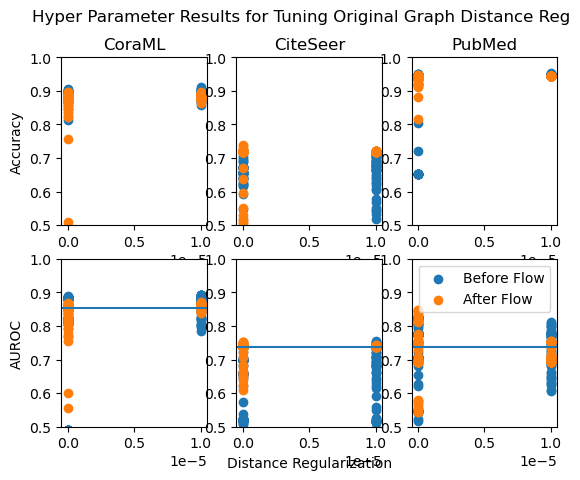

In [ ]:
# df = results_orig.results_df
flow_df = df[df['dist_embedding_beta']]
embd_df = df[np.logical_not(df['dist_embedding_beta'])]
plt.figure()
plt.ylabel("Accuracy")
for i, a_dataset in enumerate(datasets):
    curr_df = flow_df[flow_df['dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['val_accuracy'])
    plt.title(a_dataset)
    if i == 0:  
        plt.ylabel("Accuracy")
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    if i == 0:  
        plt.ylabel("AUROC")
        
    curr_df = embd_df[embd_df['dataset'] == a_dataset]
    plt.subplot(2, len(datasets), i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['val_accuracy'])
    plt.ylim(0.5, 1)
    plt.subplot(2, len(datasets), len(datasets)+i+1)
    plt.scatter(curr_df['dist_reg'], curr_df['test_ood_detection_epistemic_auroc'])
    plt.ylim(0.5, 1)
    if i == 1:
        plt.xlabel("Distance Regularization")
    if a_dataset == 'CoraML':
        bnds = .852
    if a_dataset == 'CiteSeer':
        bnds = .7373
    if a_dataset == 'Pubmed':
        bnds = .6925
    plt.axhline(bnds)

plt.legend(["Before Flow", "After Flow"])
plt.suptitle("Hyper Parameter Results for Tuning Original Graph Distance Reg")

In [ ]:
# dfs = {}
for a_dataset in pd.unique(df["config/data/dataset"]):
    dfs[a_dataset] = df[df["config/data/dataset"] == a_dataset]

KeyError: 'config/data/dataset'

In [ ]:
a_dataset = datasets[7]
dfs[a_dataset]['training_iteration']
# for a_key in dfs[a_dataset].keys():
#     print(a_key)
all_keys = ["config/model/" + a_key for a_key in keys] + ['config/data/dataset', 'val_accuracy', 'test_ood_detection_epistemic_auroc', 'test_accuracy']
dfs[a_dataset][all_keys].sort_values('val_accuracy')

In [ ]:
for a_dataset in datasets:
    curr_df =  dfs[a_dataset][all_keys]
    print(a_dataset)
    for i, KNN_K in enumerate(pd.unique(curr_df['config/model/KNN_K'])):
        K_df = curr_df[curr_df['config/model/KNN_K'] == KNN_K]
        val_selected_test_acc = K_df.iloc[np.argmax(K_df['val_accuracy'])]['test_accuracy']
        val_selected_roc = K_df.iloc[np.argmax(K_df['val_accuracy'])]['test_ood_detection_epistemic_auroc']
        best_roc = K_df.iloc[np.argmax(K_df['test_ood_detection_epistemic_auroc'])]['test_ood_detection_epistemic_auroc']
        print(f"for k={KNN_K} best val selected accuracy {val_selected_test_acc:.4f}, selected ROC: {val_selected_roc:.4f}, best overall {best_roc:.4f}")
        # curr_df[curr_df['config/model/KNN_K'] == KNN_K].plot.scatter(x='config/model/dist_reg', y='config/model/dist_sigma', c='test_ood_detection_epistemic_auroc', logx=True, logy=True, vmin=.8628)
        # plt.title(f"KNN_K = {KNN_K}")
        # plt.show()
    print()